In [1]:
import os
import zipfile
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [9]:
# Config file
RAW_PATH = "../../data/raw"
PROCESSED_PATH = "../../data/processed"

In [77]:
# Utils file
import joblib

def dump(value = None, filename = None):
    if value is not None and filename is not None:
        joblib.dump(value=value, filename=filename)
        
    else:
        raise ValueError("value and filename cannot be None".capitalize())
    
def load(filename):
    if os.path.exists(filename):
        return joblib.load(filename=filename)
    else:
        raise Exception("File not found".capitalize())

In [89]:
class Loader:
    def __init__(self, image_path = None, batch_size = 4):
        self.image_path = image_path
        self.batch_size = batch_size
        self.base_images = list()
        self.mask_images = list()

    def base_transforms(self):
        return transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def mask_transforms(self):
        return transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Normalize([0.5], [0.5])
        ])

    def unzip_folder(self):
        if os.path.exists(RAW_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(os.path.join(RAW_PATH, "segmented"))
        else:
            raise Exception("Raw data folder not found".capitalize())

    def process_segmented_data(self):
        if os.path.join(RAW_PATH, "segmented"):
            self.images_directory = os.path.join(RAW_PATH, "segmented")

            self.base_directory = os.path.join(
                self.images_directory, os.listdir(self.images_directory)[0]
            )
            self.mask_directory = os.path.join(
                self.images_directory, os.listdir(self.images_directory)[1]
            )

            self.categories = os.listdir(self.base_directory)

            for category in self.categories:
                base_folder_path = os.path.join(self.base_directory, category)
                mask_folder_path = os.path.join(self.mask_directory, category)

                for image in os.listdir(base_folder_path):
                    if image in os.listdir(mask_folder_path):
                        self.base_images.append(
                            self.base_transforms()(
                                Image.fromarray(
                                    cv2.imread(os.path.join(base_folder_path, image))
                                )
                            )
                        )
                        self.mask_images.append(
                            self.mask_transforms()(
                                Image.fromarray(
                                    cv2.imread(os.path.join(mask_folder_path, image))
                                )
                            )
                        )

            return self.base_images, self.mask_images
        else:
            raise Exception(
                "Segmented data folder not found in the raw folder".capitalize()
            )

    def create_dataloader(self):
        images, masks = self.process_segmented_data()
        data_split = train_test_split(images, masks, test_size=0.30, random_state=42)

        train_dataloader = DataLoader(
            dataset=list(zip(data_split[0], data_split[2])),
            batch_size=self.batch_size,
            shuffle=True,
        )
        val_dataloader = DataLoader(
            dataset=list(zip(data_split[1], data_split[3])),
            batch_size=self.batch_size * 6,
            shuffle=True,
        )

        try:
            if os.path.exists(PROCESSED_PATH):
                dump(value=train_dataloader, filename=os.path.join(PROCESSED_PATH, "train_dataloader.pkl"))
                dump(value=val_dataloader, filename=os.path.join(PROCESSED_PATH, "val_dataloader.pkl"))
            else:
                raise Exception("Processed data folder not found".capitalize())

        except ValueError as e:
            print("Exception caught in the section - {}".format(e).capitalize())

In [90]:
loader = Loader(image_path="/Users/shahmuhammadraditrahman/Desktop/cell.zip", batch_size=4)
loader.unzip_folder()

In [91]:
loader.create_dataloader()

In [92]:
train_dataloader = load(filename="../../data/processed/train_dataloader.pkl")
val_dataloader = load(filename="../../data/processed/val_dataloader.pkl")

In [99]:
train_images, train_masks = next(iter(train_dataloader))
val_images, val_masks = next(iter(val_dataloader))

print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([24, 3, 256, 256]) torch.Size([24, 1, 256, 256])


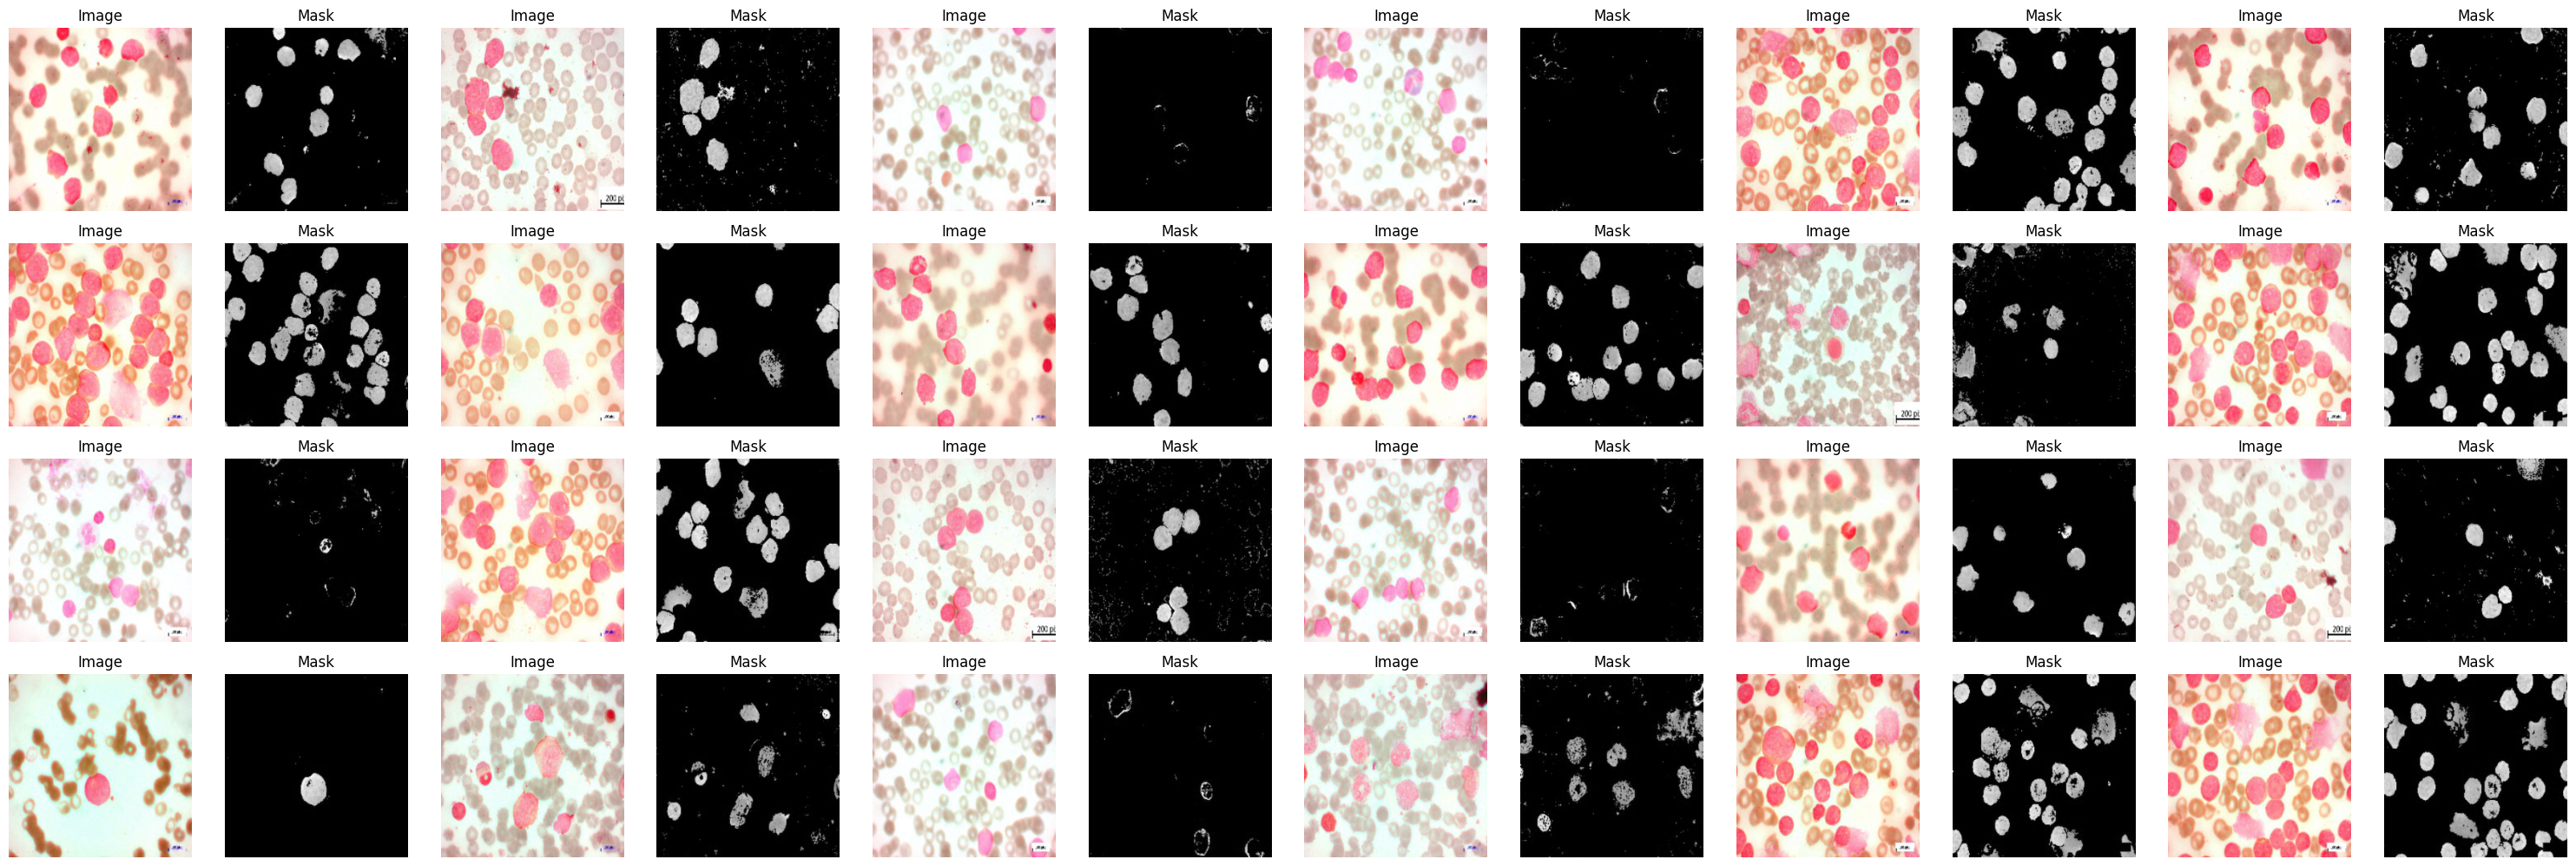

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))

for index, image in enumerate(val_images):
    plt.subplot(2 * 4, 2 * 6, 2 * index + 1)
    image = image.permute(1, 2, 0)
    image = (image - image.min())/(image.max() - image.min())
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(2*4, 2*6, 2*index + 2)
    masks = val_masks[index].permute(1, 2, 0)
    masks = (masks - masks.min())/(masks.max() - masks.min())
    plt.imshow(masks, cmap="gray")
    plt.title("Mask")
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [6]:
from collections import OrderedDict


class Encoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.encoder_block()

    def encoder_block(self):
        layers = OrderedDict()
        layers["conv1"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["relu1"] = nn.ReLU(inplace=True)
        layers["conv2"] = nn.Conv2d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["batch_norm1"] = nn.BatchNorm2d(self.out_channels)
        layers["relu2"] = nn.ReLU(inplace=True)

        return nn.Sequential(layers)

    def forward(self, x):
        return self.model(x) if x is not None else None


if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    assert encoder(torch.randn(64, 3, 256, 256)).shape == (64, 64, 256, 256)

In [7]:
from collections import OrderedDict


class Decoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.decoder_block()

    def decoder_block(self):
        layers = OrderedDict()
        layers["deconv1"] = nn.ConvTranspose2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=2,
            stride=2,
        )
        return nn.Sequential(layers)

    def forward(self, x, skip_info):
        if x is not None and skip_info is not None:
            return torch.cat((self.model(x), skip_info), dim=1)
        else:
            raise ValueError("Input and skip_info cannot be None".capitalize())


if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    decoder = Decoder(in_channels=64, out_channels=64)

    skip_info = encoder(torch.randn(64, 3, 256, 256))
    noise_samples = torch.randn(64, 64, 128, 128)

    assert decoder(noise_samples, skip_info).shape == (64, 128, 256, 256)